# Use MyModel-IDEAL Model

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import tomli
import matplotlib.pyplot as plt
from os import environ
from pathlib import Path
from buildings_bench import load_torch_dataset
from buildings_bench.models import model_factory

/global/homes/n/nrushad/.conda/envs/BuildingsBenchEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DataHandler:
    def __init__(self): pass

    def load_dataset(self, dataset_name, scaler_transform):
        dataset = load_torch_dataset(
            name=dataset_name,
            apply_scaler_transform=scaler_transform,
            scaler_transform_path=Path(environ["TRANSFORM_PATH"])
        )
        return dataset

    def create_dataloader(self, building_dataset):
        dataloader = torch.utils.data.DataLoader(
                        building_dataset,
                        batch_size=360,
                        shuffle=False)
        return dataloader

In [3]:
import torch
import torch.nn as nn

class MyRNN(nn.Module):    
    def __init__(self,
                 hidden_size=3,
                 lstm_layers=1,
                 context_len=168,
                 pred_len=24,
                 continuous_loads=True,
                 **args):
        super().__init__()

        self.context_len = context_len
        self.hidden_size = hidden_size
        self.pred_len = pred_len
        self.continuous_loads = continuous_loads
        self.lstm_layers = lstm_layers

        self.power_embedding = nn.Linear(1, 64)
        self.building_embedding = nn.Embedding(2, 32)
        self.lat_embedding = nn.Linear(1, 32)
        self.lon_embedding = nn.Linear(1, 32)

        self.encoder = nn.LSTM(160, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.decoder = nn.LSTM(160, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, 1)  # Final prediction

    def forward(self, x):
        # Embedding input features
        lat = self.lat_embedding(x['latitude'])                  # [B, T, 32]
        lon = self.lon_embedding(x['longitude'])                 # [B, T, 32]
        btype = self.building_embedding(x['building_type'].squeeze(-1))  # [B, T, 32]
        load = self.power_embedding(x['load'])     # [B, T, 64]

        time_series_inputs = [lat, lon, btype, load]

        # Concatenate all embeddings
        time_series_embed = torch.cat(time_series_inputs, dim=2)  # [B, T, 256]

        # Encode context sequence
        context_seq = time_series_embed[:, :self.context_len, :]  # [B, 168, 256]
        _, (h_n, c_n) = self.encoder(context_seq)  # hidden and cell states for decoder

        # Prepare decoder input (repeat last context embedding)
        decoder_input = time_series_embed[:, self.context_len - 1:self.context_len, :].repeat(1, self.pred_len, 1)

        # Decode
        decoder_out, _ = self.decoder(decoder_input, (h_n, c_n))  # [B, 24, hidden_size]
        
        return decoder_out

    def predict(self, x):
        out = self.forward(x)
        output = self.output_layer(out).squeeze(-1)  # [B, 24]
        return output

In [4]:
def main(model_name, dataset_name, scaler_transform, device):
    handler = DataHandler()
    dataset = handler.load_dataset(dataset_name, scaler_transform)    

    model = MyRNN()
    model = model.to(device)

    target_list = []
    prediction_list = []

    
    for building_id, building_dataset in dataset:
            
        inverse_transform = building_dataset.datasets[0].load_transform.undo_transform
        dataloader = handler.create_dataloader(building_dataset)
            
        for batch in dataloader:
            for key, value in batch.items():
                batch[key] = value.to(device)

            with torch.no_grad():
                predictions = model.predict(batch)
  
        targets = batch['load'][:, 168:]
        targets = inverse_transform(targets)
        target_list.append(targets.detach().cpu())

        predictions = inverse_transform(predictions)
        prediction_list.append(predictions.detach().cpu())

    prediction_list = torch.cat(prediction_list)
    target_list = torch.cat(target_list)
    
    return prediction_list, target_list

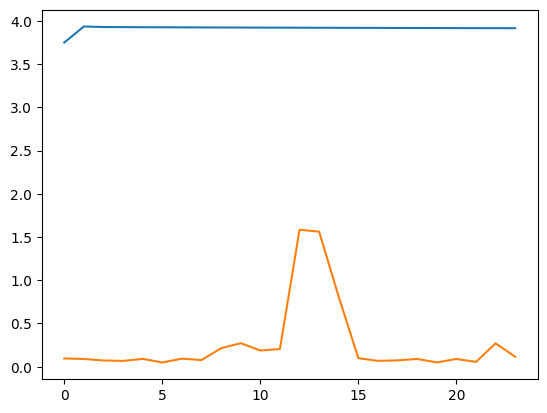

In [5]:
if __name__ == "__main__":

    DATASET = 'ideal' # Electricity | SMART | Ideal | lcl 
    DEVICE = 'cuda:0'
    MODEL = 'MyModel' 
    SCALER_TRANSFORM = 'boxcox'

    PATH = '/pscratch/sd/n/nrushad'
    environ["PATH"] = PATH
    
    environ["REPO_PATH"] = f'{PATH}/BuildingsBenchTutorial/BuildingsBench/'
    environ["BUILDINGS_BENCH"] = f'{PATH}/Dataset'
    environ["TRANSFORM_PATH"] = f'{PATH}/Dataset/metadata/transforms'
    
    prediction_list, target_list = main(MODEL, DATASET, SCALER_TRANSFORM, DEVICE)
    plt.plot(prediction_list[2].squeeze())
    plt.plot(target_list[2].squeeze())